In [219]:
import os as os
import sys as sys
import glob as glob
import math as math
import numpy as np
import scipy as sc
import subprocess as subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import genfromtxt
from scipy import stats
from functools import reduce
from shutil import copyfile


In [15]:
import parmed as pmd
import pytraj as pt

In [16]:
pt.__version__

'1.0.8.dev0+86bb5af'

# Read in sample data for ethanol and calculate the density.

I know you can the density directly from the simulation output and indeed, I'm sure that is faster, but for now this is good practice running `cpptraj` in a loop.

The experimental value is 0.7893 g cm −3 from CRC (p. 320 of physical constants of organic compounds).

In [17]:
simulation_directory = '../sample-data/pure-ethanol/'
parameter_file       = 'full.topo'
trajectory_files     = 'traj.001'
dt                   = 10.0  # picoseconds (dt = 0.002 * 5000 steps/frame)

In [18]:
cpptraj_input = '''
parm {0}
trajin {1}
unwrap
diffusion average {2}
'''.format(simulation_directory + parameter_file, simulation_directory + trajectory_files, dt)

If we wanted to go through `pytraj`, we could load in the trajectory like this, but I think it would be slow:
```
pt_trajectory = pt.iterload(simulation_directory + trajectory_files, simulation_directory + parameter_file)
```
And then run `pytraj.all_actions.diffusion(traj, mask='', tstep=1.0, individual=False, top=None, dtype='dataset', frame_indices=None)`.

In [19]:
state = pt.load_cpptraj_state(cpptraj_input)
state.run()

CpptrajState, include:
<datasetlist: 11 datasets>

In [20]:
state.data['average[D]'].values

array([ 13.0378217 ,  13.37186875,  13.1838143 ,  12.55778204])

In [21]:
for dataset in state.data:
    print(dataset)

<pytraj.datasets.DatasetTopology: size=9000, key=full.topo> 
<pytraj.datasets.DatasetDouble: size=100, key=average[X]> 
values: 
[   0.            5.22245717    8.80575599 ...,  266.33497171  273.66801782
  274.99426381]
<pytraj.datasets.DatasetDouble: size=100, key=average[Y]> 
values: 
[   0.            4.94090717    8.41001025 ...,  264.37018608  269.65782134
  269.72946968]
<pytraj.datasets.DatasetDouble: size=100, key=average[Z]> 
values: 
[   0.            4.88053531    7.5625751  ...,  249.20578938  251.57853079
  250.97566634]
<pytraj.datasets.DatasetDouble: size=100, key=average[R]> 
values: 
[   0.           15.04389965   24.77834133 ...,  779.91094717  794.90436995
  795.69939983]
<pytraj.datasets.DatasetDouble: size=100, key=average[A]> 
values: 
[  0.           3.87864663   4.97778478 ...,  27.92688574  28.19404848
  28.20814421]
<pytraj.datasets.DatasetDouble: size=4, key=average[D]> 
values: 
[ 13.0378217   13.37186875  13.1838143   12.55778204]
<pytraj.datasets.DatasetS

In [100]:
pt_trajectory = pt.iterload(simulation_directory + trajectory_files, simulation_directory + parameter_file)

In [45]:
frame = pt_trajectory[0]
frame.box

<Box: ortho, (x, y, z, alpha, beta, gamma) = (46.18144632963842, 46.182443253221905, 46.18344017680542, 90.0, 90.0, 90.0)>

In [59]:
x_values = pt.density(pt_trajectory, density_type = 'mass', delta = 0.25, direction = 'z')['z']
density_series = pt.density(pt_trajectory, density_type = 'mass', delta = 0.25, direction = 'z')['*']

In [60]:
print(density_series[1:-1])

[ 0.44352  1.08864  5.0752  ...,  5.62944  0.92736  0.16128]


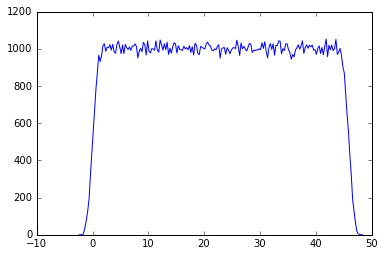

In [61]:
plt.plot(x_values, density_series)

In [43]:
pt.density(pt_trajectory, density_type = 'mass', delta = frame.box[1], direction = 'y')

OrderedDict([('*',
              array([   0.        ,    6.13676757,  986.83191944,    4.55324459,    0.        ])),
             ('sd(*)',
              array([  0.        ,  65.43506531,  83.43054338,  75.13803612,   0.        ])),
             ('y',
              array([ -69.27366488,  -23.09122163,   23.09122163,   69.27366488,
                      115.45610813]))])

In [44]:
pt.density(pt_trajectory, density_type = 'mass', delta = frame.box[2], direction = 'z')

OrderedDict([('*',
              array([   0.        ,    6.44587928,  986.56245238,    4.49206727,    0.        ])),
             ('sd(*)',
              array([  0.        ,  69.28637766,  77.77169486,  57.71537174,   0.        ])),
             ('z',
              array([ -69.27516027,  -23.09172009,   23.09172009,   69.27516027,
                      115.45860044]))])

In [103]:
pt_trajectory.topology.n_residues / pt.volume(pt_trajectory)

array([ 0.01015241,  0.01020376,  0.01045001, ...,  0.01035352,
        0.01022501,  0.01035067])

In [124]:
(np.sum(pt_trajectory.topology.mass) * 1.66) / pt.volume(pt_trajectory) # 1.66 gram/amu

array([ 0.77638428,  0.78031119,  0.7991426 , ...,  0.79176336,
        0.78193615,  0.79154588])

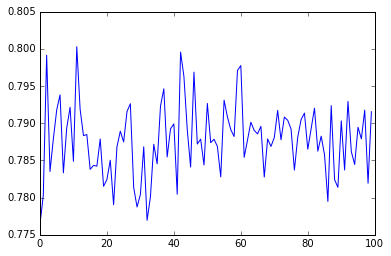

In [126]:
plt.plot((np.sum(pt_trajectory.topology.mass) * 1.66) / pt.volume(pt_trajectory))

In [191]:
parameters = pmd.load_file(simulation_directory + parameter_file)

In [192]:
parameters.LJ_types

{'c3': 1, 'h1': 4, 'hc': 3, 'ho': 5, 'oh': 2}

In [193]:
parameters.LJ_radius[0]

1.9080000000152688

In [194]:
parameters.LJ_depth[0]

0.10939999991572774

In [195]:
# changeLJSingleType <mask> <radius> <depth>

In [196]:
from parmed.tools import changeLJSingleType

In [197]:
action = changeLJSingleType(parameters, "@%c3", parameters.LJ_radius[0], 0.12)

In [198]:
action.execute()

In [199]:
print(str(action))

Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.1200 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)


In [200]:
# Outparm

In [201]:
from parmed.tools import outparm, parmout

In [205]:
parameters.save("test.prmtop")

In [161]:
# Add LJType seems incorrect! It just adds another line in the prmtop.

In [423]:
def get_density(parameter_file, trajectory_files, experimental):
    pt_trajectory = pt.iterload(trajectory_files, parameter_file)
    density = np.mean((np.sum(pt_trajectory.topology.mass) * 1.660539040) / pt.volume(pt_trajectory)) # 1.66 gram/amu
    return experimental - density

In [442]:
# def write_parameters(simulation_directory, parameter_file, parameter_step):
#     parameters = pmd.load_file(simulation_directory + parameter_file)
#     action = changeLJSingleType(parameters, "@%c3", parameters.LJ_radius[0], parameters.LJ_depth[0] + parameter_step)
#     action.execute()
#     print(str(action))
#     parameters.save('parameters-c3-depth-{}.prmtop'.format(parameters.LJ_depth[0] + parameter_step))
#     return parameters.LJ_depth[0] + parameter_step, 'parameters-c3-depth-{}.prmtop'.format(parameters.LJ_depth[0] + parameter_step)

In [462]:
def write_parameters(simulation_directory, parameter_file, value):
    print(value[0])
    parameters = pmd.load_file(simulation_directory + parameter_file)
    action = changeLJSingleType(parameters, "@%c3", parameters.LJ_radius[0], value[0])
    action.execute()
    try:
        parameters.save('parameters-c3-depth-{}.prmtop'.format(value[0]))
    except:
        # the parameters already exist
        pass
    return value, 'parameters-c3-depth-{}.prmtop'.format(value[0])

In [463]:
def prepare_simulation_files(parameter_file):
    mdin_text = '''
Production, NPT, ? ns (super short for testing)
&cntrl
  ntx=1,
  ntc=2,
  ntf=2,
  dt=0.002,
  nstlim=500,
  cut=8.0,
  temp0=298.16,
  iwrap=1,
  ntt=3,
  ig=-1,
  gamma_ln=2.0,
  ntp=1,
  barostat=1,
  taup=3.0,
  ntpr=500,
  ntwr=500,
  ntxo=2,
  ntwx=100,
  ioutfm=1,
  ntwe=100,
/
'''
    
    pmemd_text = '''
    #!/usr/bin/env bash
    source $AMBERHOME/amber.sh
    pmemd -O -p {} -c full.crds -i mdin -o mdout.001 -r rst.001 -x traj.001 -e mden.001 -inf mdinfo.001
    '''.format(parameter_file)
    
    # os.mkdir(simulation_directory)
    copyfile('../pure-ethanol/full.crds', os.getcwd() + 'full.crds')
    file = open('mdin', 'w')
    file.write(mdin_text)
    file.close()
                             
    file = open('run.sh' ,'w')
    file.write(pmemd_text)
    file.close()             

In [464]:
def run_simulation():
    os.system('bash ' + os.getcwd() + '/run.sh')

Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.0094 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0651054815779
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.0294 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0645526845412
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.0494 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0641984075195
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.0694 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0640210034205
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.0894 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0625459530198
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.1094 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0616126070518
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.1294 (kal/mol) and radius from 1.9080 to 1.9080 (Angstroms)
0.0609485637293
Changing @%c3 Lennard-Jones well depth from 0.1094 to 0.1494 (kal/mol) and r

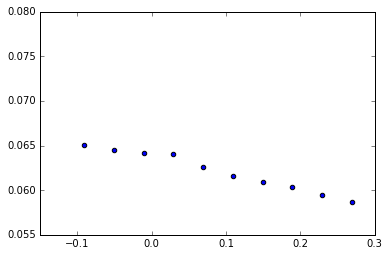

In [437]:
sample_data_directory = '../pure-ethanol/'
sample_parameters = 'full.topo'
sample_trajectory = 'traj.001'
new_simulation_root_directory = '../sample-data/loop/'

fig = plt.figure()
ax = fig.add_subplot(111)

for increment in np.arange(-0.1, 0.1, 0.02):
    os.chdir('/home/dslochower/data/projects/QMFF/sample-data/loop/')
    LJ_depth, new_parameter_file = write_parameters(sample_data_directory, sample_parameters, increment)
    prepare_simulation_files(new_parameter_file)
    run_simulation()
    print(get_density(new_parameter_file, 'traj.001', 0.7893))
    ax.scatter(LJ_depth, get_density(new_parameter_file, 'traj.001', 0.7893))

In [441]:
pmd.__version__

'2.5.1+94.g1348a5e'

In [450]:
def run_optimize(value):
    os.chdir('/home/dslochower/data/projects/QMFF/sample-data/loop/')
    LJ_depth, new_parameter_file = write_parameters(sample_data_directory, sample_parameters, value)
    prepare_simulation_files(new_parameter_file)
    run_simulation()
    return get_density(new_parameter_file, 'traj.001', 0.7893)

In [451]:
import scipy.optimize

In [465]:
sc.optimize.fmin(run_optimize, 0.05)

0.05
0.0525
0.055
0.05125
0.05125
0.05375
0.051875
0.051875
0.053125
0.0521875
0.0521875
0.0528125
0.05234375
0.05234375
0.0521875
0.052421875
0.052421875
Optimization terminated successfully.
         Current function value: 0.063770
         Iterations: 6
         Function evaluations: 17


array([ 0.05234375])